<a href="https://colab.research.google.com/github/donyeun/AMLSII_19-20_SN18154195/blob/master/AMLS_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries and Variables

In [17]:
! pip install torchviz ekphrasis

In [18]:
import pandas as pd
import os
import torch
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import csv

import tensorboard as tb
import tensorflow as tf
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# Load the TensorBoard notebook extension
%load_ext tensorboard




The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
cfg = {
       'paths': {
           'train_folder_task_a': '/content/drive/My Drive/public/AMLSII_19-20_SN18154195/dataset/training/2017_English_final/GOLD/Subtask_A',
           'train_additional_dataset_filenames': ['livejournal-2014test-A.tsv', 'sms-2013test-A.tsv'],
           'test_file_task_a': '/content/drive/My Drive/public/AMLSII_19-20_SN18154195/dataset/testing/SemEval2017-task4-test/SemEval2017-task4-test.subtask-A.english.txt',

           'train_folder_task_b': '/content/drive/My Drive/public/AMLSII_19-20_SN18154195/dataset/training/2017_English_final/GOLD/Subtasks_BD',
           'test_file_task_b': '/content/drive/My Drive/public/AMLSII_19-20_SN18154195/dataset/testing/SemEval2017-task4-test/SemEval2017-task4-test.subtask-BD.english.txt',
       },
       'task_a': {
           'use_additional_dataset': False,
           'dataset': {
               'clean' : {
                   'training_filepath': '/content/drive/My Drive/public/AMLSII_19-20_SN18154195/dataset/clean/task_a_training.csv'
               }
           }
       },
       'preprocessing': {
           'tokenization': {
               'remove_twitter_handle': True,
               'preserve_case': False
           }
       },
}

# Load Dataset and Data Preprocessing

## Preprocess Additional Dataset
In task A, there are some additional datasets (sms and livejournal datasets) that were given from the competition apart from the standard twitter corpus. We can use both of these additional datasets, after we preprocess the formatting so that it matches the rest of the twitter datasets.

In [20]:
task_a_train_additional_dfs = {}

for filename in cfg['paths']['train_additional_dataset_filenames']:
  # read additional corpora
  task_a_train_additional_dfs[filename] = pd.read_csv(os.path.join(cfg['paths']['train_folder_task_a'], filename), sep='\t', header=None, quoting=csv.QUOTE_NONE)
  
  if filename == 'livejournal-2014test-A.tsv':
    # remove the 0-th column from livejournal corpora, as it is unnecessary
    task_a_train_additional_dfs[filename] = task_a_train_additional_dfs[filename].drop(columns=[0])
  elif filename == 'sms-2013test-A.tsv':
    # remove the 1st column from sms corpora, as it is unnecessary
    task_a_train_additional_dfs[filename] = task_a_train_additional_dfs[filename].drop(columns=[1])
  
  # reset the column index to make it incremental
  task_a_train_additional_dfs[filename].columns = range(task_a_train_additional_dfs[filename].shape[1])
  
  print(task_a_train_additional_dfs[filename])

             0         1                                                  2
0     LJ111111  negative  I know I missed something here , but what does...
1     LJ111113   neutral  What do you think of Beside Ourselves as a tit...
2     LJ111114  positive                    :D I intend to be one someday .
3     LJ111117  negative  LLLINKKK LLLINKKK IIIMAGEEELLLINKKK The choice...
4     LJ111119   neutral                     LLLINKKK Some more mountains .
...        ...       ...                                                ...
1137  LJ113616  positive                     Maybe it was - his - fantasy ?
1138  LJ113618  negative  It was ok , but they always just seem so nervo...
1139  LJ113621  positive  It is streamable from YepRoc -- matter of fact...
1140  LJ113623  positive  comment telling me who you are , or how you fo...
1141  LJ113625   neutral  im on myspace ... ill try and find you and add...

[1142 rows x 3 columns]
          0         1                                          

## Make Datasets As Pandas' DataFrames and Cleaning Dataset



In [0]:
def append_txt_files_as_one_dataframe(folderpath, filename_keywords_list, additional_dataset_dfs=None):
  dataset_per_file_dfs = {}
  dataset_df = pd.DataFrame()
  filenames = os.listdir(folderpath)
  
  # open txt files (in tsv formatting)
  for filename in filenames:
    # if the filename contains a keyword in the filename_keywords_list, then open the txt file
    # this is to avoid opening unnecessary txt such as readme.txt file.
    if any(keyword in filename for keyword in filename_keywords_list):
      dataset_per_file_dfs[filename] = pd.read_csv(os.path.join(folderpath, filename), sep="\t", header=None, quoting=csv.QUOTE_NONE)
      print('shape : ', dataset_per_file_dfs[filename].shape, '\tfilename: ', filename)

  # combine the original dataset with additional dataset (if any)
  if additional_dataset_dfs is not None:
    for key, value in additional_dataset_dfs.items():
      dataset_per_file_dfs[key] = value

  # append all the files as one dataframe
  for key, value in dataset_per_file_dfs.items():
    # print(key, '\t', i, '\t', dataset_per_file_df[key].shape[0])
    dataset_df = dataset_df.append(dataset_per_file_dfs[key], ignore_index=True)
  return dataset_df

In [0]:
def clean_dataframe_format(df, new_column_name_list, drop_column_list=[]):
  # drop unnecessary column
  df = df.drop(columns=drop_column_list)
  
  # rename column
  df.columns = new_column_name_list

  # remove row in dataframe if the 'text' or 'sentiment' column value is missing
  df = df.dropna(subset=['sentiment', 'text'], how='any').reset_index(drop=True)
  
  # remove row if the sentiment is not 'positive', 'negative' or 'neutral'
  # this happens in the dataset, for example, there are some rows
  # where its sentiments are 'off topic'
  valid_sentiments = ['positive', 'negative', 'neutral']
  df = df[df['sentiment'].isin(valid_sentiments)].reset_index(drop=True)
  return df

In [23]:
# read dataset files and append it as one pandas dataframe
if cfg['task_a']['use_additional_dataset']:
  task_a_train_df = append_txt_files_as_one_dataframe(cfg['paths']['train_folder_task_a'], ['twitter'], task_a_train_additional_dfs)
else:
  task_a_train_df = append_txt_files_as_one_dataframe(cfg['paths']['train_folder_task_a'], ['twitter'])

task_a_train_df = clean_dataframe_format(task_a_train_df, ['id', 'sentiment', 'text'], drop_column_list=[3])

shape :  (2000, 3) 	filename:  twitter-2016devtest-A.txt
shape :  (1999, 3) 	filename:  twitter-2016dev-A.txt
shape :  (6000, 3) 	filename:  twitter-2016train-A.txt
shape :  (1654, 3) 	filename:  twitter-2013dev-A.txt
shape :  (3547, 3) 	filename:  twitter-2013test-A.txt
shape :  (9684, 3) 	filename:  twitter-2013train-A.txt
shape :  (1853, 3) 	filename:  twitter-2014test-A.txt
shape :  (2390, 3) 	filename:  twitter-2015test-A.txt
shape :  (489, 3) 	filename:  twitter-2015train-A.txt
shape :  (86, 3) 	filename:  twitter-2014sarcasm-A.txt
shape :  (20633, 4) 	filename:  twitter-2016test-A.txt


In [24]:
task_b_train_df = append_txt_files_as_one_dataframe(cfg['paths']['train_folder_task_b'], ['twitter'])
task_b_train_df = clean_dataframe_format(task_b_train_df, ['id', 'topic','sentiment', 'text'], drop_column_list=[4])
task_b_train_df.info()

shape :  (4346, 4) 	filename:  twitter-2016train-BD.txt
shape :  (1325, 4) 	filename:  twitter-2016dev-BD.txt
shape :  (1417, 4) 	filename:  twitter-2016devtest-BD.txt
shape :  (489, 4) 	filename:  twitter-2015train-BD.txt
shape :  (10552, 5) 	filename:  twitter-2016test-BD.txt
shape :  (2383, 5) 	filename:  twitter-2015testBD.txt
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20508 entries, 0 to 20507
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         20508 non-null  object
 1   topic      20508 non-null  object
 2   sentiment  20508 non-null  object
 3   text       20508 non-null  object
dtypes: object(4)
memory usage: 641.0+ KB


In [25]:
task_a_test_df = pd.read_csv(cfg['paths']['test_file_task_a'], sep='\t', header=None, quoting=csv.QUOTE_NONE)
task_a_test_df = clean_dataframe_format(task_a_test_df, ['id', 'sentiment', 'text'])
task_a_test_df

,id,sentiment,text
0,801989080477154944,neutral,#ArianaGrande Ari By Ariana Grande 80% Full ht...
1,801989272341453952,positive,Ariana Grande KIIS FM Yours Truly CD listening...
2,801990978424962944,positive,Ariana Grande White House Easter Egg Roll in W...
3,801996232553963008,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...
4,801998343442407040,neutral,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...
...,...,...,...
12279,805699615781625856,positive,@dansen17 update: Zac Efron kissing a puppy ht...
12280,805701709356003328,neutral,#zac efron sex pic skins michelle sex https://...
12281,805701818357579776,neutral,First Look at Neighbors 2 with Zac Efron Shirt...
12282,805703557081075712,neutral,zac efron poses nude #lovely libra porn https:...


In [26]:
task_b_test_df = pd.read_csv(cfg['paths']['test_file_task_b'], sep='\t', header=None, quoting=csv.QUOTE_NONE)
task_b_test_df = clean_dataframe_format(task_b_test_df, ['id', 'topic', 'sentiment', 'text'])
task_b_test_df

,id,topic,sentiment,text
0,801989272341453952,#ArianaGrande,positive,Ariana Grande KIIS FM Yours Truly CD listening...
1,801990978424962944,#ArianaGrande,positive,Ariana Grande White House Easter Egg Roll in W...
2,801996232553963008,#ArianaGrande,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...
3,801998343442407040,#ArianaGrande,positive,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...
4,802001659970744064,#ArianaGrande,positive,Hairspray Live! Previews at the Macy's Thanksg...
...,...,...,...,...
6180,805696468959002624,zac efron,positive,"Abby *talking about the Hamilton soundtrack"": ..."
6181,805699412257181697,zac efron,positive,can we like get zac efron or justin bieber for...
6182,805699615781625856,zac efron,positive,@dansen17 update: Zac Efron kissing a puppy ht...
6183,805701818357579776,zac efron,positive,First Look at Neighbors 2 with Zac Efron Shirt...


In [0]:
# Checking and compare the frequency with what's written in the paper
# # save dataset as csv file
# task_a_train_df.to_csv('coba_train_a.csv', sep='\t')

# assert task_a_train_df[task_a_train_df['sentiment'] == 'positive'].shape[0] == 19902  #SALAH
assert task_a_train_df[task_a_train_df['sentiment'] == 'negative'].shape[0] == 7840
assert task_a_train_df[task_a_train_df['sentiment'] == 'neutral'].shape[0] == 22591

assert task_a_test_df[task_a_test_df['sentiment'] == 'positive'].shape[0] == 2375
assert task_a_test_df[task_a_test_df['sentiment'] == 'negative'].shape[0] == 3972
assert task_a_test_df[task_a_test_df['sentiment'] == 'neutral'].shape[0] == 5937

assert len(task_b_train_df['topic'].unique()) == 373
assert task_b_train_df[task_b_train_df['sentiment'] == 'positive'].shape[0] == 14951
assert task_b_train_df[task_b_train_df['sentiment'] == 'negative'].shape[0] == 4013
assert task_b_train_df[task_b_train_df['sentiment'] == 'neutral'].shape[0] == 1544


assert len(task_b_test_df['topic'].unique()) == 125
assert task_b_test_df[task_b_test_df['sentiment'] == 'positive'].shape[0] == 2463
assert task_b_test_df[task_b_test_df['sentiment'] == 'negative'].shape[0] == 3722

## Tokenization

In [28]:
from sklearn.preprocessing import LabelEncoder
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.classes.preprocessor import TextPreProcessor

text_processor = TextPreProcessor(
  # normalized these terms (ex: "google.com" into "<url>")
  normalize = ['url', 'email', 'percent', 'money', 'phone', 'user',
              'time', 'date', 'number'],

  # annotate these terms (ex: "#win" into ["<hashtag>", "win", "</hashtag>"])
  annotate = {'hashtag', 'allcaps', 'elongated', 'repeated', 'emphasis', 'censored'},
  fix_html=True,
  segmenter = 'twitter',
  corrector='twitter',
  unpack_hashtags=True,
  unpack_contractions=True,
  # spell_correct_elong=False,
  spell_correct_elong=True,
  tokenizer = SocialTokenizer(lowercase=True).tokenize,
  dicts = [emoticons]
)

def tokenize_df(df, input_column_name='text', output_column_name='tokenized'):
  df[output_column_name] = df.apply(
    lambda row: text_processor.pre_process_doc(
        row[input_column_name]
    ),
    axis=1)
  
  return df

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


In [29]:
# tokenizer = nltk.tokenize.TweetTokenizer(
#     strip_handles = cfg['preprocessing']['tokenization']['remove_twitter_handle'],
#     preserve_case = cfg['preprocessing']['tokenization']['preserve_case']
# )

task_a_train_df = tokenize_df(task_a_train_df)
task_b_train_df = tokenize_df(task_b_train_df)
task_a_test_df = tokenize_df(task_a_test_df)
task_b_test_df = tokenize_df(task_b_test_df)


# print sample result
task_b_test_df.head(10)

,id,topic,sentiment,text,tokenized
0,801989272341453952,#ArianaGrande,positive,Ariana Grande KIIS FM Yours Truly CD listening...,"[ariana, grande, <allcaps>, kiis, fm, </allcap..."
1,801990978424962944,#ArianaGrande,positive,Ariana Grande White House Easter Egg Roll in W...,"[ariana, grande, white, house, easter, egg, ro..."
2,801996232553963008,#ArianaGrande,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...,"[<hashtag>, cd, </hashtag>, <hashtag>, musics,..."
3,801998343442407040,#ArianaGrande,positive,SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...,"[<allcaps>, side, to, side, </allcaps>, 😘, <us..."
4,802001659970744064,#ArianaGrande,positive,Hairspray Live! Previews at the Macy's Thanksg...,"[hairspray, live, !, previews, at, the, macy, ..."
5,802003380973568000,#ArianaGrande,positive,#LindsayLohan Is ‘Feeling Thankful’ After Blas...,"[<hashtag>, lindsay, lohan, </hashtag>, is, ‘,..."
6,802014830467174016,#ArianaGrande,negative,I hate her but... I love her songs Dammit ._.#...,"[i, hate, her, but, ., <repeated>, i, love, he..."
7,802022559520673024,#ArianaGrande,positive,My idols are #littlemix #justinbieber #arianag...,"[my, idols, are, <hashtag>, little, mix, </has..."
8,802024085777629056,#ArianaGrande,positive,#Beauty #ArianaGrande-CHRISTMAS & CHILL-JAPAN ...,"[<hashtag>, beauty, </hashtag>, <hashtag>, ari..."
9,802028835013206016,#ArianaGrande,positive,#Beauty #ArianaGrande-THE REMIX-JAPAN ONLY #CD...,"[<hashtag>, beauty, </hashtag>, <hashtag>, ari..."


# Exploratory Data Analysis (EDA)

## Word Cloud

In [0]:
def show_wordcloud(text, title, max_words=200):
  wc = WordCloud(
      max_words=max_words,
      background_color='white',
      # ranks_only= frequency
  ).generate(text)

  print(wc.words_)

  fig = plt.figure(1, figsize=(12, 12))
  fig.suptitle(title)
  plt.imshow(wc)
  plt.show()

Microsoft, I may not prefer your gaming branch of business. But, you do make a damn fine operating system. #Windows10 @Microsoft
<class 'str'>
{'verse': 1.0, 'wrote': 1.0, 'book': 1.0, 'stand': 1.0, 'titlea': 1.0, 'kampung': 1.0}


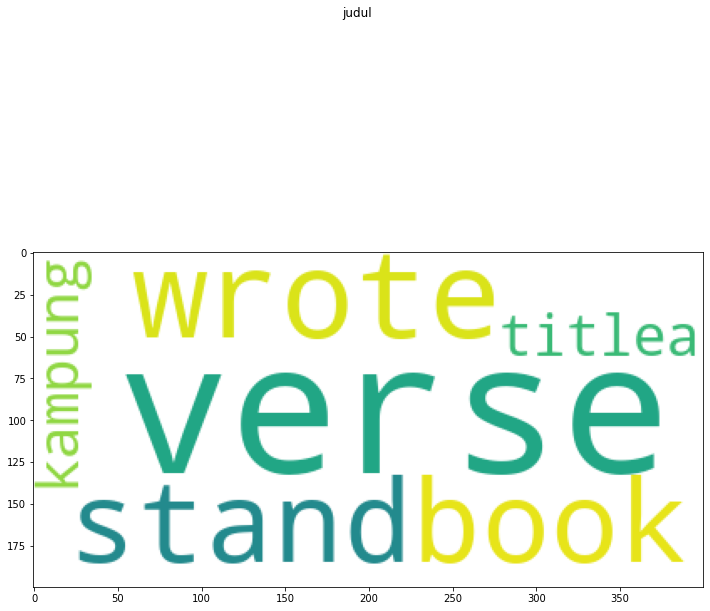

In [31]:
df = task_b_train_df[task_b_train_df['sentiment'] == 'positive']['text'][4]
print(df)
# print(df.shape)
# show_wordcloud(str(df.values), 'judul', max_words=20000)

# print(df.shape)
word_string = "you verse wrote book stand titlea i you you you kampung"
print(type(word_string))
show_wordcloud(word_string, 'judul', max_words=20000)

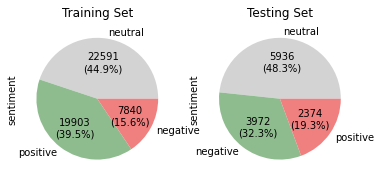

In [105]:
def show_autopct(pct, data):
  absolute = int(pct/100.*np.sum(data))
  return  "{:d}\n({:.1f}%)".format(absolute, pct)
  
plt.subplot(1, 2, 1)
task_a_train_df['sentiment'].value_counts().plot(
    kind='pie',
    autopct=lambda pct: show_autopct(pct, task_a_train_df['sentiment'].value_counts()),
    colors=['lightgray', 'darkseagreen', 'lightcoral']
);
plt.title('Training Set');


plt.subplot(1, 2, 2)
task_a_test_df['sentiment'].value_counts().plot(
    kind='pie',
    # figsize=(7,4),
    autopct=lambda pct: show_autopct(pct, task_a_test_df['sentiment'].value_counts()),
    colors=['lightgray', 'darkseagreen', 'lightcoral']
);
plt.title('Testing Set');




In [0]:
task_b_train_df[task_b_train_df['text'].str.contains('not')]

,id,topic,sentiment,text,tokenized
4,629226490152914944,@microsoft,positive,"Microsoft, I may not prefer your gaming branch...","[microsoft, ,, i, may, not, prefer, your, gami..."
8,629797991826722816,@microsoft,negative,"After attempting a reinstall, it still bricks,...","[after, attempting, a, reinstall, ,, it, still..."
16,631543121407442946,@microsoft,negative,@Microsoft support for 365 has been terrible. ...,"[<user>, support, for, <number>, has, been, te..."
20,632536348419690496,@microsoft,negative,@eyesonfoxorg @Microsoft I'm still using Vista...,"[<user>, <user>, i, am, still, using, vista, o..."
22,632810315227467776,@microsoft,negative,@MisterMetokur @Microsoft @ATT @NSAGov That's ...,"[<user>, <user>, <user>, <user>, that, ', s, c..."
...,...,...,...,...,...
20474,520384978820296705,yougov,negative,"""@LouiseBaldock great work; you may or may not...","["", <user>, great, work, ;, you, may, or, may,..."
20476,519600072971927555,yougov,neutral,"""YouGov tonight shows 2% Labour lead. So head...","["", yougov, tonight, shows, <percent>, labour,..."
20481,519201436102848512,yougov,neutral,IF tonight's YouGov shows another Tory lead th...,"[if, tonight, ', s, yougov, shows, another, to..."
20488,520337071345795073,yougov,neutral,"""Tonight's YouGov: Lab 35, Con 30, UKIP 15, Li...","["", tonight, ', s, yougov, :, lab, <number>, ,..."


In [0]:
task_b_train_df.tokenized[0]

['dear',
 '<user>',
 'the',
 'newooffice',
 'for',
 'mac',
 'is',
 'great',
 'and',
 'all',
 ',',
 'but',
 'no',
 'lync',
 'update',
 '?',
 'c',
 "'",
 'mon',
 '.']

                       positive  negative  neutral
kyle                          9       4.0      6.0
ac/dc                        89       2.0      NaN
atleti                        3       3.0     10.0
tegan                         9       2.0      8.0
boko haram                    2     149.0      NaN
randy orton                  36       7.0      NaN
bernie sanders               76       9.0      NaN
arian foster                  8       3.0      6.0
labor day                    61       7.0      NaN
tony blair                   10      65.0      NaN
ipad                         63       4.0      NaN
thor                        138      18.0      NaN
angela merkel                23      23.0      NaN
federer                      75       1.0      NaN
dark souls                   73      14.0      NaN
adidas                        1       1.0      8.0
chris maguire                 2       1.0      2.0
paper towns                 167       8.0      NaN
curtis                       86

<BarContainer object of 303 artists>

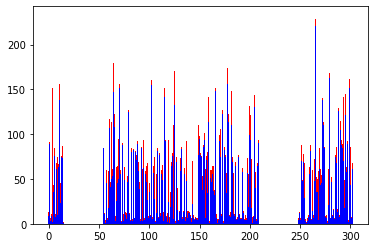

In [53]:
positive = task_b_train_df[task_b_train_df['sentiment'] == 'positive']['topic'].value_counts(sort=False).to_frame(name='positive')
negative = task_b_train_df[task_b_train_df['sentiment'] == 'negative']['topic'].value_counts(sort=False).to_frame(name='negative')
neutral = task_b_train_df[task_b_train_df['sentiment'] == 'neutral']['topic'].value_counts(sort=False).to_frame(name='neutral')
# negative = task_b_train_df['topic'][task_b_train_df['sentiment'] == 'negative'].value_counts(sort=False)
# neutral = task_b_train_df['topic'][task_b_train_df['sentiment'] == 'neutral'].value_counts(sort=False)
joined = positive.join(negative).join(neutral)

joined = joined[(joined['positive'] > 0) & (joined['negative']>0)]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(joined)

<BarContainer object of 303 artists>

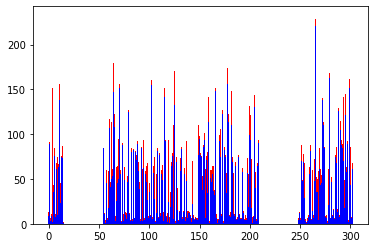

In [54]:

plt.bar(range(joined.shape[0]), joined['positive'], label='positive', color='blue')
plt.bar(range(joined.shape[0]), joined['negative'], label='negative', color='red', bottom=joined['positive'])

# Pytorch

## Build Dataset


In [0]:
from torch.utils.data import DataLoader, Dataset
import csv

# class TextDataset(Dataset):
#   @staticmethod
#   def sort_key(ex):
#       return len(ex.text)

#   def __init__(self, dataset_df):
#     self.samples = []

#     for idx, row in dataset_df.iterrows():
#       if idx == 101:
#         break
#       self.samples.append( (row['text'], row['sentiment']) )

#   def __len__(self):
#     return len(self.samples)

#   def __getitem__(self, idx):
#     text, sentiment = self.samples[idx]
#     # return self.transform(self.x_data[index]), self.transform(self.y_data[index])
#     return (text, sentiment).ToTensor()

  

# task_a_trainset = TextDataset(task_a_train_df)
# dataloader = DataLoader(
#                 task_a_trainset,
#                 batch_size=50,
#                 num_workers=2
#              )

In [0]:
# for i, batch in enumerate(dataloader):
#   for sample in batch:
#     print(batch)
#   print(">>>>>>>")

# task_a_trainset

In [0]:
from torchtext import data



In [0]:
task_a_train_df = task_a_train_df[['text', 'sentiment']]
# task_a_train_df.to_csv('train_a.csv', sep='\t', index=False)
task_a_train_df.to_csv('train_a.csv', sep='\t', index_label='row_num')

task_a_test_df = task_a_test_df[['text', 'sentiment']]
# task_a_test_df.to_csv('test_a.csv', sep='\t', index=False)
task_a_test_df.to_csv('test_a.csv', sep='\t', index_label='row_num')


In [0]:
from sklearn.preprocessing import LabelEncoder
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.classes.preprocessor import TextPreProcessor

text_processor = TextPreProcessor(
  # normalized these terms (ex: "google.com" into "<url>")
  normalize = ['url', 'email', 'percent', 'money', 'phone', 'user',
              'time', 'date', 'number'],

  # annotate these terms (ex: "#win" into ["<hashtag>", "win", "</hashtag>"])
  annotate = {'hashtag', 'allcaps', 'elongated', 'repeated', 'emphasis', 'censored'},
  fix_html=True,
  segmenter = 'twitter',
  corrector='twitter',
  unpack_hashtags=True,
  unpack_contractions=True,
  spell_correct_elong=False,
  tokenizer = SocialTokenizer(lowercase=True).tokenize,
  dicts = [emoticons]
)

def custom_tokenizer(example):
  return text_processor.pre_process_doc(example)



Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [0]:
ROW_NUM = data.Field()
TEXT = data.Field(tokenize=custom_tokenizer, include_lengths=True)

SENTIMENT = data.LabelField(dtype = torch.int)

train_data_a = data.TabularDataset(
    path='train_a.csv',
    format='tsv',
    fields = [('row_num', ROW_NUM), ('text', TEXT), ('sentiment', SENTIMENT)],
    # fields = [('row_num', ROW_NUM), (None, None), ('sentiment', SENTIMENT), ('text', TEXT)],
    skip_header=True
)

test_data_a = data.TabularDataset(
    path='test_a.csv',
    format='tsv',
    fields = [('row_num', ROW_NUM), ('text', TEXT), ('sentiment', SENTIMENT)],
    skip_header=True
)


train_data_a, valid_data_a = train_data_a.split()

print(len(train_data_a))
print(len(valid_data_a))
print(len(test_data_a))


35234
15100
12284


In [0]:
vars(train_data_a.examples[0])

{'row_num': ['24018'],
 'sentiment': 'positive',
 'text': ['"',
  '<hashtag>',
  '3',
  'dt',
  '</hashtag>',
  'make',
  'sure',
  'you',
  'find',
  'your',
  'self',
  'at',
  'the',
  '\\',
  '"',
  '"',
  '"',
  '"',
  's.e.c',
  '\\',
  '"',
  '"',
  '"',
  '"',
  'this',
  'thursday',
  'for',
  '<money>',
  'thursdays',
  '!',
  '<repeated>',
  '<money>',
  'w',
  '/',
  'college',
  'id',
  '<money>',
  'w',
  '/',
  'reg',
  'id',
  'til',
  '<time>',
  '!',
  '<repeated>',
  '<hashtag>',
  'i',
  'party',
  '</hashtag>',
  '"']}

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data_a, valid_data_a, test_data_a), 
    batch_sizes = (BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),
    sort_key=lambda x: len(x.text),
    sort_within_batch = True,
    device = device)

## Build Vocabulary

In [0]:
ROW_NUM.build_vocab(train_data_a)
SENTIMENT.build_vocab(train_data_a)

In [0]:
print(SENTIMENT.vocab.freqs.most_common())
for key, value in SENTIMENT.vocab.stoi.items():
  print(key, value)

print(ROW_NUM.vocab.freqs.most_common())
for key, value in ROW_NUM.vocab.stoi.items():
  print(key, value)

Streaming output truncated to the last 5000 lines.
48815 30237
48816 30238
48817 30239
48818 30240
4882 30241
48820 30242
48822 30243
48823 30244
48824 30245
48825 30246
48826 30247
48827 30248
48828 30249
48829 30250
48833 30251
48834 30252
48835 30253
48836 30254
48837 30255
48838 30256
4884 30257
48840 30258
48841 30259
48846 30260
48847 30261
48848 30262
48849 30263
4885 30264
48852 30265
48853 30266
48854 30267
48855 30268
48856 30269
48857 30270
48858 30271
48859 30272
4886 30273
48860 30274
48861 30275
48862 30276
48863 30277
48864 30278
48865 30279
48868 30280
48869 30281
48870 30282
48872 30283
48873 30284
48874 30285
48876 30286
48877 30287
48878 30288
48879 30289
4888 30290
48881 30291
48882 30292
48883 30293
48884 30294
48885 30295
48886 30296
48887 30297
48889 30298
4889 30299
48890 30300
48891 30301
48893 30302
48894 30303
48895 30304
48897 30305
48898 30306
48899 30307
489 30308
48901 30309
48902 30310
48903 30311
48905 30312
48906 30313
48907 30314
48908 30315
48909 303

In [0]:
TEXT.build_vocab(train_data_a,
                 max_size = 50000,
                 vectors = 'fasttext.en.300d',
                #  vectors = 'glove.twitter.27B.200d',
                 unk_init = torch.Tensor.normal_
                 )

# TEXT.build_vocab(train_data_a,
#                 #  max_size = 25000,
#                 #  vectors = 'glove.twitter.27B.200d',
#                 #  unk_init = torch.Tensor.normal_
#                  )


tot = 0
for batch in train_iterator:
  # print(batch.batch_size)
  tot += batch.batch_size
print(tot)

# print(len(train_data_a))

print(TEXT.vocab.freqs.most_common(100))
print(TEXT.vocab.itos[:10])

.vector_cache/wiki.en.vec: 0.00B [00:00, ?B/s]


HTTPError: ignored

In [0]:
for batch in train_iterator:
  i = int(ROW_NUM.vocab.itos[int(batch.row_num[0][0])])
  print(task_a_train_df.iloc[i].text)
  for elm in torch.transpose(batch.text[0], 0, 1)[0].detach().cpu().clone().numpy().transpose():
    print(TEXT.vocab.itos[int(elm)], sep=' ', end=' ')
  # print(batch.text)
  break
  

In [0]:
print(TEXT.vocab.freqs.most_common(20))
print(TEXT.vocab.itos[:10])

In [0]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(SENTIMENT.vocab)}")

## Neural Network

three layers:
1. embedding layer (transform one-hot encoding vector into a dense embedding vector)
2. RNN
3. linear layer (output)

In [0]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
               bidirectional, dropout, pad_idx):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
    # self.rnn = nn.RNN(embedding_dim, hidden_dim)
    self.rnn = nn.LSTM(embedding_dim,
                       hidden_dim,
                       num_layers=n_layers,
                       bidirectional=bidirectional,
                       dropout=dropout
                       )
    self.fully_connected = nn.Linear(hidden_dim*2, output_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, text, text_length):
    # text dimention is [sentence len, batch size]
    
    # embedded dimention is [sentence len, batch size, embedding_dim]
    embedded = self.dropout(self.embedding(text))

    # pack the sequence
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_length)
    # print('packed_embedded:')
    # print(packed_embedded)
    packet_output, (hidden, cell) = self.rnn(packed_embedded)

    # unpack the sequence
    output, output_length = nn.utils.rnn.pad_packed_sequence(packet_output)

    # output dimention is [sentence len, batch size, hidden dim * num directions]
    # output over padding tokens are zero tensors

    # hidden dimension is [num layers*num directions, batch size, hidden dim]
    # cell dimension is also [num layers*num directions, batch size, hidden dim]

    #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
    #and apply dropout

    # hidden dimension is [batch size, hid dim*num directions]
    hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
    
    return self.fully_connected(hidden)


In [0]:
INPUT_DIM = len(TEXT.vocab)
# EMBEDDING_DIM = 200
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = len(SENTIMENT.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model = RNN(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX,
            )

In [0]:
def count_model_params(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
  # n_params = sum(p.numel() for p in model.parameters)
  
print(model.parameters)
print(count_model_params(model))


In [0]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

In [0]:
# replace the initial weights of the embedding layer with the pretrained embeddings
model.embedding.weight.data.copy_(pretrained_embeddings)

In [0]:
# initialise UNK and PAD tokens to zeros
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

In [0]:
for p in model.parameters():
  # print(p)
  print(p.numel())

## Train the Model

In [0]:
import torch.optim as optim

optimiser = optim.Adam(model.parameters())

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)
criterion = criterion.to(device)

In [0]:
# def binary_accuracy(preds, y):
#     """
#     Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
#     """

#     #round predictions to the closest integer
#     rounded_preds = torch.round(torch.sigmoid(preds))
#     rounded_preds = torch.round(preds)
#     correct = (rounded_preds == y).float() #convert into float for division
#     acc = correct.sum() / len(correct)
#     return acc

# def categorical_accuracy(preds, y):
#   """
#   Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
#   """
#   max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
#   correct = max_preds.squeeze(1).eq(y)
#   return correct.sum() / torch.FloatTensor([y.shape[0]])

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
def calculate_performance(y, preds):
  # get the index of the max probability 
  max_preds = preds.argmax(dim = 1, keepdim = True).squeeze(1)
  max_preds = max_preds.detach().cpu().clone().numpy()
  
  y = y.detach().cpu().clone().numpy()


  # max_samples = 2
  # for i in range(len(y)-1):
  #   if max_preds[i] != y[i]:
  #     print('pred=', SENTIMENT.vocab.itos[max_preds[i]], ' actual=', SENTIMENT.vocab.itos[y[i]], end=' ')
  #     for elm in torch.transpose(texts, 0, 1)[0].detach().cpu().clone().numpy().transpose():
  #       print(TEXT.vocab.itos[int(elm)], sep=' ', end=' ')
  #     print
  #     max_samples -= 1
  #   if max_samples <= 0:
  #     break

  acc = accuracy_score(y, max_preds)
  rec = recall_score(y, max_preds, average='macro')
  prec= precision_score(y, max_preds, average='macro')
  f1  = f1_score(y, max_preds, average='macro')
  return acc, rec, prec, f1



In [0]:


def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_rec = 0
    epoch_prec = 0
    epoch_f1 = 0

    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        text, text_length = batch.text
        # predictions = model(text).squeeze(1)
        predictions = model(text, text_length).squeeze(1)
        
        
        loss = criterion(predictions, batch.sentiment.long())
        
        # acc = categorical_accuracy(predictions, batch.sentiment)
        acc, rec, prec, f1 = calculate_performance(batch.sentiment, predictions)
        # print(acc, rec, prec, f1)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_rec += rec.item()
        epoch_prec += prec.item()
        epoch_f1 += f1.item()

        avg_loss = epoch_loss / len(iterator)
        avg_acc = epoch_acc / len(iterator)
        avg_rec = epoch_rec / len(iterator)
        avg_prec = epoch_prec / len(iterator)
        avg_f1 = epoch_f1 / len(iterator)
    return avg_loss, avg_acc, avg_rec, avg_prec, avg_f1

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_rec = 0
    epoch_prec = 0
    epoch_f1 = 0
    
    model.eval()
    
    actual_file = open('actual.txt', 'w')
    pred_file = open('pred.txt', 'w')
    with torch.no_grad():
    
        for batch in iterator:
            text, text_length = batch.text
            predictions = model(text, text_length).squeeze(1)
            actuals = batch.sentiment
            for elm in actuals:
              actual_file.write(str(elm.item()) + '\n')
            
            preds = predictions.argmax(dim = 1, keepdim = True).squeeze(1)
            for elm in preds:
              pred_file.write(str(elm.item()) + '\n')
 
            # loss = criterion(predictions, batch.sentiment.long())
            loss = criterion(predictions, batch.sentiment.long())
            
            # acc = categorical_accuracy(predictions, batch.sentiment)
            # acc, rec, prec, f1 = calculate_performance(batch.sentiment, predictions)
            acc, rec, prec, f1 = calculate_performance(batch.sentiment, predictions)
            # print(acc, rec, prec, f1)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_rec += rec.item()
            epoch_prec += prec.item()
            epoch_f1 += f1.item()

            avg_loss = epoch_loss / len(iterator)
            avg_acc = epoch_acc / len(iterator)
            avg_rec = epoch_rec / len(iterator)
            avg_prec = epoch_prec / len(iterator)
            avg_f1 = epoch_f1 / len(iterator)
    return avg_loss, avg_acc, avg_rec, avg_prec, avg_f1

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
from torch.utils.tensorboard import SummaryWriter

summary_writer = SummaryWriter()

N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, train_rec, train_prec, train_f1 = train(model, train_iterator, optimiser, criterion)
    valid_loss, valid_acc, valid_rec, valid_prec, valid_f1 = evaluate(model, valid_iterator, criterion)

    summary_writer.add_scalar("training/loss", train_loss, epoch)
    summary_writer.add_scalar("training/accuracy", train_acc, epoch)
    summary_writer.add_scalar("training/recall", train_rec, epoch)
    summary_writer.add_scalar("training/precision", train_prec, epoch)
    summary_writer.add_scalar("training/F1", train_f1, epoch)

    summary_writer.add_scalar("validation/loss", valid_loss, epoch)
    summary_writer.add_scalar("validation/accuracy", valid_acc, epoch)
    summary_writer.add_scalar("validation/recall", valid_rec, epoch)
    summary_writer.add_scalar("validation/precision", valid_prec, epoch)
    summary_writer.add_scalar("validation/F1", valid_f1, epoch)
    
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')
    print(f'\tTrain Acc : {train_acc*100:.2f}% | Val. Acc : {valid_acc*100:.2f}%')
    print(f'\tTrain Rec : {train_rec*100:.2f}% | Val. Rec : {valid_rec*100:.2f}%')
    print(f'\tTrain Prec: {train_prec*100:.2f}% | Val. Prec: {valid_prec*100:.2f}%')
    print(f'\tTrain F1  : {train_f1*100:.2f}% | Val. F1  : {valid_f1*100:.2f}%')

# after completing all epochs, visualise the word vectors
vectors = model.embedding.weight.data
labels = [l for l in TEXT.vocab.itos]
summary_writer.add_embedding(vectors, metadata=labels)
summary_writer.close()

In [0]:
# %tensorboard --logdir runs

In [0]:
# model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc, test_rec, test_prec, test_f1 = evaluate(model, test_iterator, criterion)
#DONY
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Acc : {test_acc*100:.2f}%')
print(f'Test Rec : {test_rec*100:.2f}%')
print(f'Test Prec: {test_prec*100:.2f}%')
print(f'Test F1  : {test_f1*100:.2f}%')

In [0]:
# 15 Apr
# Test Loss: 0.828
# Test Acc : 65.16%
# Test Rec : 64.89%
# Test Prec: 62.38%
# Test F1  : 62.55%